In [5]:
# Install and load required packages

if(!require(quantmod)) { install.packages("quantmod"); library(quantmod) }
if(!require(PerformanceAnalytics)) { install.packages("PerformanceAnalytics"); library(PerformanceAnalytics) }
if(!require(tidyverse)) { install.packages("tidyverse"); library(tidyverse) }
if(!require(tseries)) { install.packages("tseries"); library(tseries) }

In [46]:
# Define sector stock lists and additional asset classes
sectors <- list(
  Technology = c("TCS.NS", "INFY.NS", "WIPRO.NS", "HCLTECH.NS", "TECHM.NS"),
  Banking = c("HDFCBANK.NS", "ICICIBANK.NS", "KOTAKBANK.NS", "AXISBANK.NS", "SBIN.NS"),
  Pharmaceuticals = c("SUNPHARMA.NS", "DIVISLAB.NS", "CIPLA.NS", "DRREDDY.NS", "BIOCON.NS"),
  FMCG = c("HINDUNILVR.NS", "ITC.NS", "NESTLEIND.NS", "BRITANNIA.NS", "DABUR.NS"),
  Automobile = c("MARUTI.NS", "TATAMOTORS.NS", "M&M.NS", "HEROMOTOCO.NS", "BAJAJ-AUTO.NS"),
  Gold = c("GC=F"),  # Gold
  Crypto = c("BTC-USD")  # Bitcoin
)

# User inputs
investment_amount <- as.numeric(readline("Enter initial investment amount (e.g., 10000 INR): "))
cat("Available sectors:", paste(names(sectors)[1:5], collapse = ", "), "\n")
sector_choice <- readline("Choose sector for stocks (excluding Gold, Crypto): ")
if (!sector_choice %in% names(sectors)[1:5]) {
  stop("Invalid sector. Choose from: ", paste(names(sectors)[1:5], collapse = ", "))
}

# Combine stocks with gold and crypto
stock_symbols <- c(sectors[[sector_choice]], sectors$Gold, sectors$Crypto)
cat("Selected assets:", paste(stock_symbols, collapse = ", "), "\n")

# Fetch data function
fetch_data <- function(symbols, from = "2020-01-01", to = "2024-01-01") {
  tryCatch({
    # Fetch data for each symbol individually to avoid full failure
    getSymbols(symbols, src = "yahoo", from = from, to = to, auto.assign = TRUE)

    # Merge closing prices, handling missing symbols
    prices <- do.call(merge, lapply(symbols, function(x) {
      if (exists(x) && !is.null(get(x))) Cl(get(x)) else NULL
    }))
    if (is.null(prices)) stop("No valid data fetched for any symbol.")
    colnames(prices) <- symbols

    # Clean prices by interpolating missing values and removing remaining NAs
    prices_clean <- na.approx(prices)  # Linear interpolation for missing values
    prices_clean <- na.omit(prices_clean)  # Remove any remaining NAs

    # Calculate log returns with proper type argument
    returns <- na.omit(ROC(prices_clean, type = "continuous"))

    list(returns = returns, prices = prices_clean)
  }, error = function(e) {
    cat("Error fetching data:", conditionMessage(e), "\n")
    return(NULL)
  })
}

# Fetch data
data <- fetch_data(stock_symbols)
if (is.null(data)) stop("Data fetch failed. Exiting.")

# Extract returns and prices
returns_df <- data$returns
prices_df <- data$prices

# Verify output
print(head(prices_df))
print(head(returns_df))

Enter initial investment amount (e.g., 10000 INR): 100000
Available sectors: Technology, Banking, Pharmaceuticals, FMCG, Automobile 
Choose sector for stocks (excluding Gold, Crypto): Technology
Selected assets: TCS.NS, INFY.NS, WIPRO.NS, HCLTECH.NS, TECHM.NS, GC=F, BTC-USD 


Warning message:
“GC=F contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”


             TCS.NS  INFY.NS WIPRO.NS HCLTECH.NS TECHM.NS     GC=F  BTC-USD
2020-01-02 2157.650 734.7000  124.150   573.5500 766.0500 1524.500 6985.470
2020-01-03 2200.650 746.0000  125.550   585.0500 775.1000 1549.200 7344.884
2020-01-04 2200.583 743.6167  125.725   584.0333 773.5333 1554.867 7410.657
2020-01-05 2200.517 741.2333  125.900   583.0167 771.9667 1560.533 7411.317
2020-01-06 2200.450 738.8500  126.075   582.0000 770.4000 1566.200 7769.219
2020-01-07 2205.850 727.9000  127.600   584.2500 777.1000 1571.800 8163.692
                  TCS.NS      INFY.NS     WIPRO.NS   HCLTECH.NS     TECHM.NS
2020-01-03  1.973311e-02  0.015263331  0.011213586  0.019852197  0.011744596
2020-01-04 -3.028714e-05 -0.003199942  0.001392880 -0.001739248 -0.002023269
2020-01-05 -3.028806e-05 -0.003210215  0.001390943 -0.001742278 -0.002027371
2020-01-06 -3.028898e-05 -0.003220553  0.001389011 -0.001745319 -0.002031490
2020-01-07  2.451104e-03 -0.014931181  0.012023415  0.003858526  0.008659119
2020-0

In [39]:
# Define Sharpe Ratio function
sharpe_ratio <- function(daily_log_returns, risk_free_rate = 0.068, trading_days = 252) {
  if (length(daily_log_returns) < 2 || all(is.na(daily_log_returns))) return(NA)
  mean_daily <- mean(daily_log_returns, na.rm = TRUE)
  sd_daily   <- sd(daily_log_returns, na.rm = TRUE)
  annual_return <- mean_daily * trading_days
  annual_sd     <- sd_daily * sqrt(trading_days)
  sharpe <- (annual_return - risk_free_rate) / annual_sd
  return(sharpe)
}

In [40]:
# Filter valid assets
valid_cols <- colSums(is.na(returns_df)) < nrow(returns_df) * 0.5
returns_df <- returns_df[, valid_cols]
stock_symbols <- colnames(returns_df)
if (ncol(returns_df) < 3) stop("Not enough valid assets. Need at least 3.")

# Optimize portfolio with minimum 10% allocation
optimize_portfolio <- function(returns, size, weight_step = 0.1) {
  combinations <- combn(colnames(returns), size, simplify = TRUE)
  min_weight <- 0.1  # Minimum allocation of 10%
  max_weight <- 1 - (size - 1) * min_weight  # Maximum weight to ensure sum = 1
  if (max_weight < min_weight) stop("Too many assets for minimum 10% allocation.")
  weights <- seq(min_weight, max_weight, by = weight_step)  # Adjusted weight range
  highest_sharpe <- -Inf
  best_weights <- NULL
  best_comb <- NULL
  best_returns <- NULL

  cat(sprintf("\nOptimizing %d-asset portfolios...\n", size))
  weight_combs <- expand.grid(rep(list(weights), size - 1))
  weight_combs <- weight_combs[rowSums(weight_combs) <= 1 - min_weight, ]  # Reserve min_weight for last asset
  weight_combs[[paste0("w", size)]] <- 1 - rowSums(weight_combs)

  # Filter out combinations where any weight is below 10%
  weight_combs <- weight_combs[apply(weight_combs, 1, function(x) all(x >= min_weight)), ]

  if (nrow(weight_combs) == 0) stop("No valid weight combinations with min 10% allocation.")

  for (i in 1:ncol(combinations)) {
    comb <- combinations[, i]
    comb_returns <- returns[, comb]

    for (j in 1:nrow(weight_combs)) {
      w <- as.numeric(weight_combs[j, ])
      port_returns <- xts(rowSums(comb_returns * w), index(comb_returns))
      sharpe <- sharpe_ratio(port_returns)

      if (!is.na(sharpe) && sharpe > highest_sharpe) {
        highest_sharpe <- sharpe
        best_weights <- setNames(w, comb)
        best_comb <- comb
        best_returns <- port_returns
      }
    }
  }

  return(list(sharpe = highest_sharpe, weights = best_weights,
              combination = best_comb, returns = best_returns))
}

# Run optimization
trio_result <- optimize_portfolio(returns_df, 3)
quint_result <- optimize_portfolio(returns_df, 5)

# Print results
print_result <- function(result, size, investment) {
  cat(sprintf("\nBest %d-asset portfolio:\n", size))
  cat("Assets:", paste(result$combination, collapse = "/"), "\n")
  cat("Weights:", paste(sprintf("%s = %.1f%%", names(result$weights),
                              result$weights * 100), collapse = ", "), "\n")
  cat(sprintf("Sharpe Ratio: %.4f\n", result$sharpe))
  port_value <- investment * cumprod(1 + result$returns)
  cat(sprintf("Final Portfolio Value: %.2f INR\n", last(port_value)))
}

print_result(trio_result, 3, investment_amount)
print_result(quint_result, 5, investment_amount)


Optimizing 3-asset portfolios...

Optimizing 5-asset portfolios...

Best 3-asset portfolio:
Assets: WIPRO.NS/HCLTECH.NS/BTC-USD 
Weights: WIPRO.NS = 10.0%, HCLTECH.NS = 70.0%, BTC-USD = 20.0% 
Sharpe Ratio: 0.6678
Final Portfolio Value: 356818.94 INR

Best 5-asset portfolio:
Assets: TCS.NS/INFY.NS/WIPRO.NS/GC=F/BTC-USD 
Weights: TCS.NS = 10.0%, INFY.NS = 10.0%, WIPRO.NS = 10.0%, GC=F = 50.0%, BTC-USD = 20.0% 
Sharpe Ratio: 0.9648
Final Portfolio Value: 387273.93 INR


In [41]:
# Function to calculate CAGR
calculate_cagr <- function(initial_value, final_value, years) {
  (final_value / initial_value)^(1 / years) - 1
}

# Function to calculate Sharpe Ratio
sharpe_ratio <- function(daily_log_returns, risk_free_rate = 0.068, trading_days = 252) {
  if (length(daily_log_returns) < 2 || all(is.na(daily_log_returns))) return(NA)
  mean_daily <- mean(daily_log_returns, na.rm = TRUE)
  sd_daily <- sd(daily_log_returns, na.rm = TRUE)
  annual_return <- mean_daily * trading_days
  annual_sd <- sd_daily * sqrt(trading_days)
  (annual_return - risk_free_rate) / annual_sd
}

# Fetch Nifty 50 data once
getSymbols("^NSEI", src = "yahoo", from = "2020-01-01", to = "2024-01-01", auto.assign = TRUE)
nifty_prices <- Cl(NSEI)

# Calculate Nifty 50 metrics
nifty_initial <- as.numeric(first(nifty_prices))
nifty_final <- as.numeric(last(nifty_prices))
years <- 4  # 2020-01-01 to 2024-01-01
nifty_cagr <- calculate_cagr(nifty_initial, nifty_final, years)
nifty_returns <- periodReturn(nifty_prices, period = "daily", type = "log")
nifty_sharpe <- sharpe_ratio(nifty_returns)

# Calculate portfolio final values and CAGRs
trio_final_value <- last(investment_amount * cumprod(1 + trio_result$returns))
quint_final_value <- last(investment_amount * cumprod(1 + quint_result$returns))
trio_cagr <- calculate_cagr(investment_amount, trio_final_value, years)
quint_cagr <- calculate_cagr(investment_amount, quint_final_value, years)

# Function to print portfolio results (includes Sharpe and CAGR)
print_result <- function(result, size, investment) {
  cat(sprintf("\nBest %d-asset portfolio:\n", size))
  cat("Assets:", paste(result$combination, collapse = "/"), "\n")
  cat("Weights:", paste(sprintf("%s = %.1f%%", names(result$weights), result$weights * 100), collapse = ", "), "\n")
  cat(sprintf("Sharpe Ratio: %.4f\n", result$sharpe))
  final_value <- last(investment * cumprod(1 + result$returns))
  cagr <- calculate_cagr(investment, final_value, years)
  cat(sprintf("Final Portfolio Value: %.2f INR\n", final_value))
  cat(sprintf("CAGR: %.2f%%\n", cagr * 100))
}

# Print portfolio results
print_result(trio_result, 3, investment_amount)
print_result(quint_result, 5, investment_amount)

# Function to compare Sharpe Ratios with Nifty 50
compare_sharpe <- function(nifty_sharpe, trio_sharpe, quint_sharpe) {
  cat("\n--- Sharpe Ratio Comparison with Nifty 50 ---\n")
  cat("3-Asset Portfolio:\n")
  if (trio_sharpe > nifty_sharpe) {
    cat("✅ Beats Nifty 50! Sharpe Ratio:", round(trio_sharpe, 4), "vs. Nifty:", round(nifty_sharpe, 4), "\n")
  } else {
    cat("❌ Underperforms Nifty 50. Sharpe Ratio:", round(trio_sharpe, 4), "vs. Nifty:", round(nifty_sharpe, 4), "\n")
  }
  cat("5-Asset Portfolio:\n")
  if (quint_sharpe > nifty_sharpe) {
    cat("✅ Beats Nifty 50! Sharpe Ratio:", round(quint_sharpe, 4), "vs. Nifty:", round(nifty_sharpe, 4), "\n")
  } else {
    cat("❌ Underperforms Nifty 50. Sharpe Ratio:", round(quint_sharpe, 4), "vs. Nifty:", round(nifty_sharpe, 4), "\n")
  }
  cat("Nifty 50 Sharpe Ratio:", round(nifty_sharpe, 4), "\n")
}

# Compare Sharpe Ratios
compare_sharpe(nifty_sharpe, trio_result$sharpe, quint_result$sharpe)

# Display CAGR summary
cat("\n--- CAGR Summary ---\n")
cat(sprintf("3-Asset Portfolio CAGR: %.2f%%\n", trio_cagr * 100))
cat(sprintf("5-Asset Portfolio CAGR: %.2f%%\n", quint_cagr * 100))
cat(sprintf("NIFTY 50 CAGR: %.2f%%\n", nifty_cagr * 100))

Warning message:
“^NSEI contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”


[1] "NSEI"

Warning message in to_period(xx, period = on.opts[[period]], ...):
“missing values removed from data”



Best 3-asset portfolio:
Assets: WIPRO.NS/HCLTECH.NS/BTC-USD 
Weights: WIPRO.NS = 10.0%, HCLTECH.NS = 70.0%, BTC-USD = 20.0% 
Sharpe Ratio: 0.6678
Final Portfolio Value: 356818.94 INR
CAGR: 37.44%

Best 5-asset portfolio:
Assets: TCS.NS/INFY.NS/WIPRO.NS/GC=F/BTC-USD 
Weights: TCS.NS = 10.0%, INFY.NS = 10.0%, WIPRO.NS = 10.0%, GC=F = 50.0%, BTC-USD = 20.0% 
Sharpe Ratio: 0.9648
Final Portfolio Value: 387273.93 INR
CAGR: 40.28%

--- Sharpe Ratio Comparison with Nifty 50 ---
3-Asset Portfolio:
✅ Beats Nifty 50! Sharpe Ratio: 0.6678 vs. Nifty: 0.3887 
5-Asset Portfolio:
✅ Beats Nifty 50! Sharpe Ratio: 0.9648 vs. Nifty: 0.3887 
Nifty 50 Sharpe Ratio: 0.3887 

--- CAGR Summary ---
3-Asset Portfolio CAGR: 37.44%
5-Asset Portfolio CAGR: 40.28%
NIFTY 50 CAGR: 15.57%


In [48]:
# Black-Scholes function
black_scholes <- function(S, K, T, r, sigma) {
  # Calculate d1 and d2
  d1 <- (log(S / K) + (r + 0.5 * sigma^2) * T) / (sigma * sqrt(T))
  d2 <- d1 - sigma * sqrt(T)

  # Calculate call and put prices
  call_price <- S * pnorm(d1) - K * exp(-r * T) * pnorm(d2)
  put_price <- K * exp(-r * T) * pnorm(-d2) - S * pnorm(-d1)

  # Return results
  return(list(call = call_price, put = put_price, d1 = d1, d2 = d2))
}

# Function to fetch stock data and calculate volatility
get_stock_data <- function(symbol, from = "2020-01-01", to = Sys.Date()) {
  getSymbols(symbol, src = "yahoo", from = from, to = to, auto.assign = TRUE)
  prices <- Cl(get(symbol))
  returns <- diff(log(prices))  # Daily log returns
  sigma <- sd(returns, na.rm = TRUE) * sqrt(252)  # Annualized volatility
  current_price <- as.numeric(last(prices))
  return(list(price = current_price, volatility = sigma))
}

# User input and calculation
cat("Enter the stock symbol (e.g., 'M&M.NS'): ")
stock_symbol <- readline()

# Fetch stock data
stock_info <- get_stock_data(stock_symbol)
S <- stock_info$price  # Current stock price
sigma <- stock_info$volatility  # Estimated volatility

# User inputs for option parameters
cat("Enter the strike price (K): ")
K <- as.numeric(readline())
cat("Enter time to expiration in years (T, e.g., 1 for 1 year): ")
T <- as.numeric(readline())
cat("Enter annual risk-free rate (r, e.g., 0.068 for 6.8%): ")
r <- as.numeric(readline())

# Calculate Black-Scholes prices
bs_result <- black_scholes(S, K, T, r, sigma)

# Display results
cat("\n--- Black-Scholes Option Prices for", stock_symbol, "---\n")
cat(sprintf("Spot Price (S): %.2f\n", S))
cat(sprintf("Strike Price (K): %.2f\n", K))
cat(sprintf("Time to Expiration (T): %.2f years\n", T))
cat(sprintf("Risk-Free Rate (r): %.2f%%\n", r * 100))
cat(sprintf("Volatility (sigma): %.2f%%\n", sigma * 100))
cat(sprintf("Call Option Price: %.2f\n", bs_result$call))
cat(sprintf("Put Option Price: %.2f\n", bs_result$put))
cat(sprintf("d1: %.4f\n", bs_result$d1))
cat(sprintf("d2: %.4f\n", bs_result$d2))

Enter the stock symbol (e.g., 'M&M.NS'): M&M.NS
Enter the strike price (K): 2000
Enter time to expiration in years (T, e.g., 1 for 1 year): 0.5
Enter annual risk-free rate (r, e.g., 0.068 for 6.8%): 0.0068

--- Black-Scholes Option Prices for M&M.NS ---
Spot Price (S): 2523.10
Strike Price (K): 2000.00
Time to Expiration (T): 0.50 years
Risk-Free Rate (r): 0.68%
Volatility (sigma): 33.90%
Call Option Price: 575.91
Put Option Price: 46.02
d1: 1.1032
d2: 0.8635


In [30]:
# Download and process Fama-French data
download.file("https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip",
              destfile = "factors.zip", mode = "wb")

unzip("factors.zip", exdir = ".")
unlink("factors.zip")

In [31]:
data.ff <- read.csv(file = "/content/F-F_Research_Data_Factors.CSV", skip = 3, header = TRUE, nrows = 1182)
data.ff$dt <- paste(data.ff$X, "01", sep = "")
data.ff$Date <- ymd(data.ff$dt)
data.ff <- data.ff[, -c(1, 6)]  # Remove original date column and dt
data.ff[, 1:4] <- data.ff[, 1:4] / 100  # Convert to decimal

In [32]:
# Subset Fama-French data to match portfolio period (2020-2024)
start_date <- "2020-01-01"
end_date <- "2024-01-01"
ff.sub <- subset(data.ff, Date >= start_date & Date <= end_date)
rownames(ff.sub) <- seq(1, nrow(ff.sub), 1)

In [33]:
# Convert 5-asset portfolio daily returns to monthly returns
quint_returns_daily <- quint_result$returns
quint_returns_xts <- xts(quint_returns_daily, order.by = index(quint_returns_daily))
quint_returns_monthly <- periodReturn(quint_returns_xts, period = "monthly", type = "log")

Warning message in log(unclass(x2)/lag(x1, K.)):
“NaNs produced”
Warning message in log(unclass(x2)/lag(x1, K.)):
“NaNs produced”


In [34]:
# Ensure dates align with Fama-French data (first day of each month)
quint_returns_monthly_df <- data.frame(Date = as.Date(index(quint_returns_monthly)),
                                       Port.Ret = coredata(quint_returns_monthly))
quint_returns_monthly_df$Date <- floor_date(quint_returns_monthly_df$Date, "month")

In [35]:
# Merge portfolio returns with Fama-French factors
combined_data <- merge(ff.sub, quint_returns_monthly_df, by = "Date", all.x = FALSE)
colnames(combined_data)[ncol(combined_data)] <- "Port.Ret"

# Calculate excess portfolio return (Port.Ret - RF)
combined_data$Port.RF <- combined_data$Port.Ret - combined_data$RF

In [36]:
# Fama-French 3-factor model
model <- lm(Port.RF ~ Mkt.RF + SMB + HML, data = combined_data)

In [37]:
# Display regression results
cat("\n--- Fama-French 3-Factor Model Results for 5-Asset Portfolio ---\n")
print(summary(model))


--- Fama-French 3-Factor Model Results for 5-Asset Portfolio ---

Call:
lm(formula = Port.RF ~ Mkt.RF + SMB + HML, data = combined_data)

Residuals:
   Min     1Q Median     3Q    Max 
-4.322 -1.460 -0.129  1.440  3.553 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  -0.1306     0.4285  -0.305    0.763
Mkt.RF       -4.5909     6.9725  -0.658    0.517
SMB          -3.5151    14.3918  -0.244    0.809
HML          -1.5929     7.7462  -0.206    0.839

Residual standard error: 2.168 on 23 degrees of freedom
  (21 observations deleted due to missingness)
Multiple R-squared:  0.03687,	Adjusted R-squared:  -0.08876 
F-statistic: 0.2935 on 3 and 23 DF,  p-value: 0.8297




Optimizing 5-asset portfolios...


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


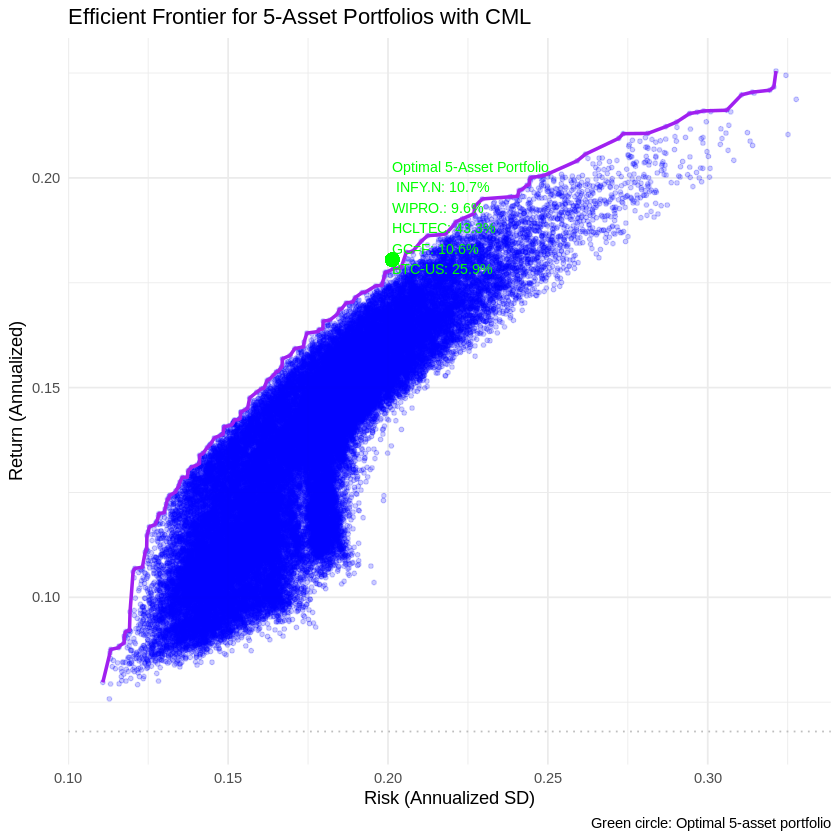

In [45]:
# Load required libraries
library(ggplot2)
library(xts)

# Function to calculate portfolio statistics
portfolio_stats <- function(returns, weights) {
  port_returns <- rowSums(returns %*% weights)
  mean_ret <- mean(port_returns, na.rm = TRUE) * 252  # Annualized return
  sd_ret <- sd(port_returns, na.rm = TRUE) * sqrt(252)  # Annualized volatility
  sharpe <- (mean_ret - 0.068) / sd_ret  # Sharpe ratio with rf = 0.068
  return(c(mean_ret, sd_ret, sharpe))
}

# Generate random 5-asset portfolios for plotting
n_portfolios <- 50000  # Number of random portfolios
set.seed(123)  # For reproducibility
all_returns <- returns_df
n_assets <- ncol(all_returns)
if (n_assets < 5) stop("Need at least 5 assets for quint portfolios.")
results <- matrix(nrow = n_portfolios, ncol = 3)  # Mean, SD, Sharpe
min_weight <- 0.1

# Select all possible 5-asset combinations
combinations <- combn(colnames(all_returns), 5, simplify = TRUE)

for (i in 1:n_portfolios) {

  comb_idx <- sample(ncol(combinations), 1)
  comb <- combinations[, comb_idx]
  comb_returns <- all_returns[, comb, drop = FALSE]

  # Generate random weights with min 10%
  weights <- runif(5, min_weight, 1)
  weights <- weights / sum(weights)
  if (any(weights < min_weight)) {
    weights <- pmax(weights, min_weight)
    weights <- weights / sum(weights)
  }

  stats <- portfolio_stats(comb_returns, weights)
  results[i, ] <- stats
}

# Convert to data frame for plotting
results_df <- data.frame(
  Risk = results[, 2],  # Annualized SD
  Return = results[, 1],  # Annualized Return
  Sharpe = results[, 3]
)

# Find the optimal 5-asset portfolio
quint_result <- optimize_quint_portfolio(all_returns, size = 5)
quint_stats <- portfolio_stats(all_returns[, quint_result$combination], quint_result$weights)


optimal_assets <- quint_result$combination
optimal_weights <- quint_result$weights
asset_label <- paste(sapply(1:5, function(i)
  paste0(substr(optimal_assets[i], 1, min(6, nchar(optimal_assets[i]))), ": ",
         round(optimal_weights[i] * 100, 1), "%")), collapse = "\n")

# Risk-free rate
rf <- 0.068

# Identify efficient frontier points (highest return for each risk level)
results_df <- results_df[order(results_df$Risk), ]
eff_frontier <- results_df[!duplicated(cummax(results_df$Return)), ]

# Plotting
p <- ggplot() +
  geom_point(data = results_df, aes(x = Risk, y = Return), color = "blue", alpha = 0.2, size = 1) +  # All portfolios
  geom_line(data = eff_frontier, aes(x = Risk, y = Return), color = "purple", size = 1) +  # Efficient frontier
  geom_point(aes(x = quint_stats[2], y = quint_stats[1]), color = "green", size = 4, shape = 16) +  # Optimal portfolio
  geom_hline(yintercept = rf, linetype = "dotted", color = "gray") +  # Risk-free rate
  labs(
    title = "Efficient Frontier for 5-Asset Portfolios with CML",
    x = "Risk (Annualized SD)",
    y = "Return (Annualized)",
    caption = "Green circle: Optimal 5-asset portfolio"
  ) +
  theme_minimal() +
  annotate("text", x = quint_stats[2], y = quint_stats[1] + 0.01,
           label = paste("Optimal 5-Asset Portfolio\n", asset_label),
           color = "green", size = 3, hjust = 0)

# Display the plot
print(p)

In [1]:
# Function to compute Black–Scholes price for European options
black_scholes_price <- function(S, K, T, r, sigma, option_type = c("call", "put")) {
  option_type <- match.arg(option_type)
  d1 <- (log(S/K) + (r + 0.5*sigma^2)*T) / (sigma*sqrt(T))
  d2 <- d1 - sigma*sqrt(T)
  if(option_type == "call") {
    price <- S * pnorm(d1) - K * exp(-r*T) * pnorm(d2)
  } else {
    price <- K * exp(-r*T) * pnorm(-d2) - S * pnorm(-d1)
  }
  return(price)
}

# Example option parameters
S <- 100        # Underlying asset price (SPOT PRICE)
K <- 105        # Strike price
T <- 0.5        # Time to maturity (years)
r <- 0.068       # Risk-free rate (annualized)
sigma <- 0.2    # Volatility (annualized)

callPrice <- black_scholes_price(S, K, T, r, sigma, option_type = "call")
putPrice  <- black_scholes_price(S, K, T, r, sigma, option_type = "put")
cat("----- Black–Scholes Option Prices -----\n")
cat("Call Price:", callPrice, "\n")
cat("Put Price: ", putPrice, "\n")



----- Black–Scholes Option Prices -----
Call Price: 4.965168 
Put Price:  6.455176 
